In [ ]:
!pip install "numpy<2" "matplotlib<3.9" --upgrade --no-cache-dir

Rows used: 248


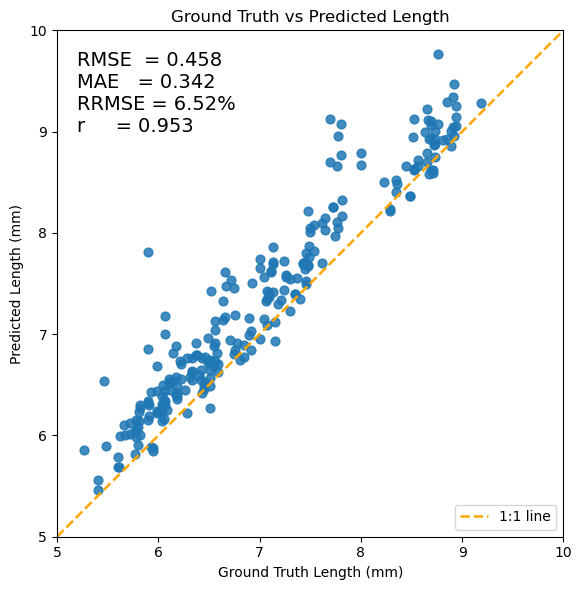

Saved: length_scatter.png


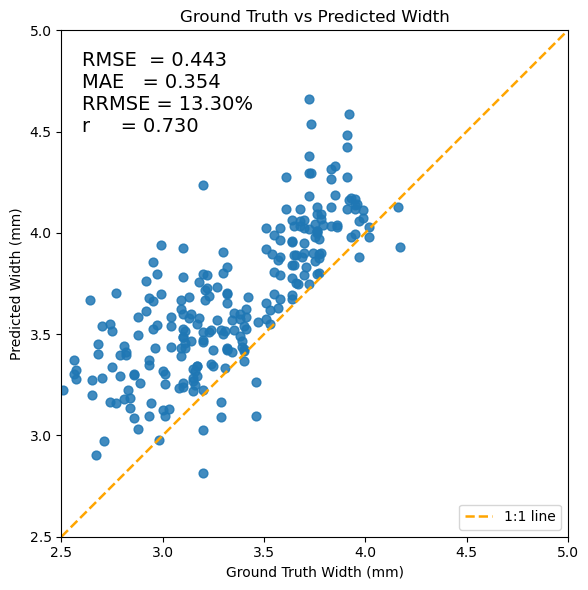

Saved: width_scatter.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path

# ---------------- CONFIG ----------------
csv_path = Path("seedKernelAssessment.csv")
COL_GT_LEN, COL_GT_WID = "gt_length_mm", "gt_width_mm"
COL_PR_LEN, COL_PR_WID = "length_mm", "width_mm"
OUT_LEN_PNG, OUT_WID_PNG = "length_scatter.png", "width_scatter.png"
POINT_ALPHA, POINT_SIZE = 0.85, 40
# ----------------------------------------

# Load data
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

# Coerce numeric
for c in [COL_GT_LEN, COL_GT_WID, COL_PR_LEN, COL_PR_WID]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop invalid rows
mask = np.isfinite(df[[COL_GT_LEN, COL_GT_WID, COL_PR_LEN, COL_PR_WID]]).all(axis=1)
df = df.loc[mask].copy()
print(f"Rows used: {len(df)}")

# Extract arrays
gt_len, pr_len = df[COL_GT_LEN].to_numpy(), df[COL_PR_LEN].to_numpy()
gt_wid, pr_wid = df[COL_GT_WID].to_numpy(), df[COL_PR_WID].to_numpy()

# Metric function
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    rrmse = (rmse / np.mean(y_true)) * 100.0
    r, _ = pearsonr(y_true, y_pred) if len(y_true) > 1 else (np.nan, np.nan)
    return rmse, mae, rrmse, r

# Scatter function
def scatter_with_identity(y_true, y_pred, title, xlab, ylab, outfile, lo, hi):
    rmse, mae, rrmse, r = compute_metrics(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=POINT_SIZE, alpha=POINT_ALPHA)
    # Orange 1:1 line
    plt.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1.8, color="orange", label="1:1 line")
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

    txt = (f"RMSE  = {rmse:.3f}\n"
           f"MAE   = {mae:.3f}\n"
           f"RRMSE = {rrmse:.2f}%\n"
           f"r     = {r:.3f}")
    plt.text(0.04, 0.96, txt, transform=plt.gca().transAxes,
             fontsize=14, va="top", ha="left",
             bbox=dict(facecolor="white", alpha=0.85, edgecolor="none"))

    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(outfile, dpi=600)
    plt.show()
    print(f"Saved: {outfile}")

# ---- Plot 1: Length (5–10 mm) ----
scatter_with_identity(
    gt_len, pr_len,
    title="Ground Truth vs Predicted Length",
    xlab="Ground Truth Length (mm)",
    ylab="Predicted Length (mm)",
    outfile=OUT_LEN_PNG,
    lo=5, hi=10
)

# ---- Plot 2: Width (2.5–5 mm) ----
scatter_with_identity(
    gt_wid, pr_wid,
    title="Ground Truth vs Predicted Width",
    xlab="Ground Truth Width (mm)",
    ylab="Predicted Width (mm)",
    outfile=OUT_WID_PNG,
    lo=2.5, hi=5
)
